In [1]:
# загружаем данные

!pip3 install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [3]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [4]:
%load_ext pycodestyle_magic

In [5]:
!chmod 600 kaggle.json

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d ajayrana/hymenoptera-data

 91% 82.0M/90.2M [00:01<00:00, 85.3MB/s]
100% 90.2M/90.2M [00:01<00:00, 77.7MB/s]


In [8]:
!unzip hymenoptera-data.zip
clear_output()

In [9]:
# Я так и не поняла, зачем датасет содержит в себе помимо директорий train и val
# ещё и директорию hymenoptera_data, в которой лежат абсолютно идентичные
# директории train и val. Но я проверила – они действительно полностью одинаковые,
# поэтому директорию hymenoptera_data со всем содержимым можно спокойно удалять.

!rm hymenoptera-data.zip
!rm -r hymenoptera_data/hymenoptera_data

In [55]:
import PIL
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from itertools import chain
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms

%matplotlib inline

In [11]:
torch.manual_seed(42)
np.random.seed(42)
clear_output()

# Данные и препроцессинг
В этот раз все изображения разного размера, поэтому перед обучением моделей необходимо привести их к единому размеру. Найдём среднюю длину стороны изображения во всём датасете и обрежем с помощью transforms.RandomCrop с аргументом pad_if_needed=True все изображения до квадрата с такой длиной стороны.

In [12]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transforms.ToTensor())

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transforms.ToTensor())

In [13]:
lenghts_train = list(chain.from_iterable([img[0][0].numpy().shape[1:]
                                          for img in hymenoptera_train]))

lenghts_val = list(chain.from_iterable([img[0][0].numpy().shape[1:]
                                        for img in hymenoptera_val]))

np.mean(lenghts_train + lenghts_val)

490.90931989924434

Округлим до 500.

In [14]:
transform = transforms.Compose([transforms.RandomCrop(500, pad_if_needed=True,
                                                      padding_mode='reflect'),
                                transforms.ToTensor()])

Теперь составим новый датасет с необходимыми трансформациями.

In [15]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transform)

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transform)

# поскольку в этот раз обучать придётся много моделей, для удобства объединим
# загрузчики для обучающей и валидационной выборки в один словарь

# так как в директориях train и val изображения сгруппированы по классам,
# перед обучением нейросети их обязательно нужно перемешать

# делать batch_size больше 8 не имеет смысла – во-первых, сам датасет небольшой
# (244 изображения в обучающей выборке и 153 в валидационной),
# во-вторых, чем больше batch_size, тем дольше будет обучаться нейросеть
# (а нам нужно обучить на этом датасете как минимум 6 моделей)

loader = {'train': torch.utils.data.DataLoader(hymenoptera_train, batch_size=8,
                                               shuffle=True, num_workers=4),
          'val': torch.utils.data.DataLoader(hymenoptera_val, batch_size=8,
                                             shuffle=True, num_workers=4)}

clear_output()

In [16]:
hymenoptera_train

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(500, 500), padding=None)
               ToTensor()
           )

In [17]:
hymenoptera_val

Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               RandomCrop(size=(500, 500), padding=None)
               ToTensor()
           )

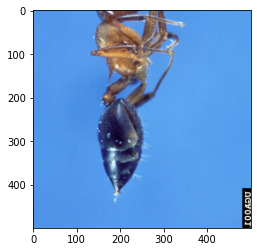

In [18]:
plt.imshow(hymenoptera_train[0][0].numpy().transpose(2, 1, 0))

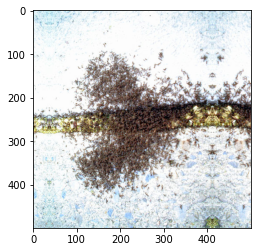

In [19]:
plt.imshow(hymenoptera_val[0][0].numpy().transpose(2, 1, 0))

# Обучение
Напишем функцию train_model.

In [20]:
def train_model(model, loader, criterion, optimizer, n_epochs):
    for epoch in tqdm(range(1, n_epochs + 1)):
        start = time.time()
        losses = []
        accuracies = []
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            curr_loss, curr_acc = 0.0, 0.0
            for X, y in loader[mode]:
                X, y = X.cuda(), y.cuda()
                with torch.set_grad_enabled(mode == 'train'):
                    y_pred = model(X)
                loss = criterion(y_pred, y)
                curr_loss += loss.item()
                curr_acc += (y_pred.argmax(dim=1) == y).sum().item()
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            losses.append(curr_loss / len(loader[mode]))
            accuracies.append(curr_acc / len(loader[mode].dataset))
        stats = """
        Epoch: {}, time: {:.1f}s
        train_loss: {:.3f}, train_acc: {:.3f}
        val_loss: {:.3f}, val_acc: {:.3f}
        """.format(epoch, time.time() - start, losses[0], accuracies[0],
                   losses[1], accuracies[1])
        print(stats)
    print(f'Final validation loss: {losses[1]:.3f}')
    print(f'Final validation accuracy: {accuracies[1]:.3f}')
    return model

## ResNet 18 и VGG 16 с нуля
### ResNet 18

In [21]:
model = models.resnet18()
model = model.cuda()

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 6.6s
        train_loss: 1.781, train_acc: 0.516
        val_loss: 0.789, val_acc: 0.569
        

        Epoch: 2, time: 6.5s
        train_loss: 0.794, train_acc: 0.553
        val_loss: 0.708, val_acc: 0.595
        

        Epoch: 3, time: 6.5s
        train_loss: 0.692, train_acc: 0.607
        val_loss: 0.675, val_acc: 0.595
        

        Epoch: 4, time: 6.6s
        train_loss: 0.695, train_acc: 0.602
        val_loss: 0.890, val_acc: 0.542
        

        Epoch: 5, time: 6.6s
        train_loss: 0.679, train_acc: 0.611
        val_loss: 0.767, val_acc: 0.621
        

        Epoch: 6, time: 6.5s
        train_loss: 0.668, train_acc: 0.631
        val_loss: 0.745, val_acc: 0.627
        

        Epoch: 7, time: 6.5s
        train_loss: 0.710, train_acc: 0.553
        val_loss: 0.828, val_acc: 0.484
        

        Epoch: 8, time: 6.7s
        train_loss: 0.657, train_acc: 0.619
        val_loss: 0.749, val_acc: 0.575
        

        Epoch: 

Финальная accuracy после 10 эпох – 0.549. Мало.

### VGG 16

In [24]:
model = models.vgg16()
model = model.cuda()

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 29.0s
        train_loss: 13.362, train_acc: 0.508
        val_loss: 1.298, val_acc: 0.458
        

        Epoch: 2, time: 27.7s
        train_loss: 0.772, train_acc: 0.455
        val_loss: 0.819, val_acc: 0.458
        

        Epoch: 3, time: 27.6s
        train_loss: 0.708, train_acc: 0.533
        val_loss: 0.693, val_acc: 0.542
        

        Epoch: 4, time: 27.8s
        train_loss: 0.727, train_acc: 0.529
        val_loss: 0.710, val_acc: 0.458
        

        Epoch: 5, time: 28.0s
        train_loss: 0.729, train_acc: 0.484
        val_loss: 0.709, val_acc: 0.458
        

        Epoch: 6, time: 27.8s
        train_loss: 0.711, train_acc: 0.459
        val_loss: 0.686, val_acc: 0.542
        

        Epoch: 7, time: 27.9s
        train_loss: 0.703, train_acc: 0.512
        val_loss: 0.706, val_acc: 0.458
        

        Epoch: 8, time: 27.9s
        train_loss: 0.713, train_acc: 0.443
        val_loss: 0.694, val_acc: 0.458
        

      

Финальная accuracy после 10 эпох – 0.458. Ещё хуже. Пока что модели без fine tuning-а показывают очень плохие результаты.

## ResNet 18 и VGG 16 с FineTuning
### ResNet 18

In [27]:
model = models.resnet18(pretrained=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 7.1s
        train_loss: 2.043, train_acc: 0.639
        val_loss: 1.785, val_acc: 0.654
        

        Epoch: 2, time: 7.2s
        train_loss: 0.768, train_acc: 0.520
        val_loss: 0.768, val_acc: 0.699
        

        Epoch: 3, time: 7.0s
        train_loss: 0.684, train_acc: 0.602
        val_loss: 0.590, val_acc: 0.719
        

        Epoch: 4, time: 7.0s
        train_loss: 0.634, train_acc: 0.660
        val_loss: 0.570, val_acc: 0.778
        

        Epoch: 5, time: 7.0s
        train_loss: 0.616, train_acc: 0.664
        val_loss: 0.523, val_acc: 0.745
        

        Epoch: 6, time: 7.0s
        train_loss: 0.557, train_acc: 0.762
        val_loss: 0.550, val_acc: 0.752
        

        Epoch: 7, time: 7.0s
        train_loss: 0.528, train_acc: 0.762
        val_loss: 0.883, val_acc: 0.667
        

        Epoch: 8, time: 6.9s
        train_loss: 0.420, train_acc: 0.820
        val_loss: 0.510, val_acc: 0.758
        

        Epoch: 

Финальная accuracy после 10 эпох – 0.66. Всё ещё не очень много, но уже заметно лучше, чем у не-предобученной модели!

### VGG 16

In [30]:
model = models.vgg16(pretrained=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 29.1s
        train_loss: 18.583, train_acc: 0.455
        val_loss: 2.276, val_acc: 0.458
        

        Epoch: 2, time: 28.6s
        train_loss: 1.011, train_acc: 0.463
        val_loss: 0.694, val_acc: 0.542
        

        Epoch: 3, time: 28.1s
        train_loss: 0.749, train_acc: 0.512
        val_loss: 0.730, val_acc: 0.458
        

        Epoch: 4, time: 28.2s
        train_loss: 0.737, train_acc: 0.508
        val_loss: 0.686, val_acc: 0.542
        

        Epoch: 5, time: 28.2s
        train_loss: 0.777, train_acc: 0.525
        val_loss: 0.691, val_acc: 0.542
        

        Epoch: 6, time: 28.3s
        train_loss: 0.759, train_acc: 0.504
        val_loss: 0.693, val_acc: 0.510
        

        Epoch: 7, time: 28.7s
        train_loss: 0.730, train_acc: 0.467
        val_loss: 0.945, val_acc: 0.542
        

        Epoch: 8, time: 28.1s
        train_loss: 0.728, train_acc: 0.480
        val_loss: 0.686, val_acc: 0.542
        

      

А вот у предобученной VGG 16 финальная accuracy на валидации вообще не улучшилась – всё ещё 0.458. Loss снизился, но настолько незначительно, что этим можно пренебречь (с 0.719 до 0.708).

## ResNet 18 и VGG 16 с FineTuning и аугментацией
### Аугментация данных
Запишем все аугментации для тестовой и валидационной выборки в переменные transform_aug_train и transform_aug_val и составим новый датасет.

In [34]:
# в этот раз приведём все изображения в обучающей выборке к единому размеру не с помощью
# transforms.RandomCrop, а с помощью transforms.RandomResizedCrop

# добавим случайное отражение по горизонтали с вероятностью 0.5,
# небольшое случайное изменение яркости, контраста и насыщенности и тона
# и поворот на случайный угол до 20 градусов

# после преобразования изображений в тензоры нормализуем их
# (значения mean и std взяла из примера в документации PyTorch)

transform_aug_train = transforms.Compose([transforms.RandomResizedCrop(500),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ColorJitter(0.05, 0.05,
                                                                 0.05, 0.05),
                                          transforms.RandomRotation(
                                              20, resample=PIL.Image.BILINEAR),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.485, 0.456, 0.406),
                                              (0.229, 0.224, 0.225))])

# преобразования валидационной выборки остались практически без изменений –
# только добавилась нормализация тензоров как в обучающей выборке

transform_aug_val = transforms.Compose(
    [transforms.RandomCrop(500, pad_if_needed=True, padding_mode='reflect'),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [35]:
hymenoptera_train = datasets.ImageFolder('hymenoptera_data/train',
                                         transform=transform_aug_train)

hymenoptera_val = datasets.ImageFolder('hymenoptera_data/val',
                                       transform=transform_aug_val)

loader = {'train': torch.utils.data.DataLoader(hymenoptera_train, batch_size=8,
                                               shuffle=True, num_workers=4),
          'val': torch.utils.data.DataLoader(hymenoptera_val, batch_size=8,
                                             shuffle=True, num_workers=4)}

clear_output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


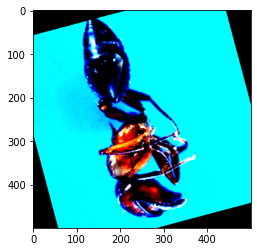

In [36]:
plt.imshow(hymenoptera_train[0][0].numpy().transpose(2, 1, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


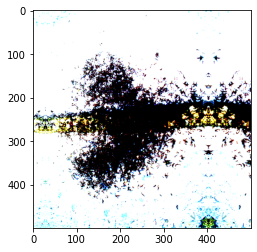

In [37]:
plt.imshow(hymenoptera_val[0][0].numpy().transpose(2, 1, 0))

Как видно, у валидационного изображения только немного изменился цвет (из-за нормализации значений тензоров), а у обучающего заметно поменялись цвет, яркость, контраст, насыщенность и угол поворота.

### ResNet 18

In [38]:
model = models.resnet18(pretrained=True)
model = model.cuda()

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 12.9s
        train_loss: 1.923, train_acc: 0.500
        val_loss: 1.132, val_acc: 0.569
        

        Epoch: 2, time: 12.9s
        train_loss: 0.654, train_acc: 0.594
        val_loss: 0.652, val_acc: 0.621
        

        Epoch: 3, time: 13.0s
        train_loss: 0.707, train_acc: 0.578
        val_loss: 0.767, val_acc: 0.523
        

        Epoch: 4, time: 13.0s
        train_loss: 0.632, train_acc: 0.652
        val_loss: 0.559, val_acc: 0.725
        

        Epoch: 5, time: 12.9s
        train_loss: 0.685, train_acc: 0.586
        val_loss: 0.665, val_acc: 0.621
        

        Epoch: 6, time: 13.2s
        train_loss: 0.660, train_acc: 0.635
        val_loss: 0.589, val_acc: 0.699
        

        Epoch: 7, time: 13.0s
        train_loss: 0.626, train_acc: 0.648
        val_loss: 0.746, val_acc: 0.667
        

        Epoch: 8, time: 12.9s
        train_loss: 0.627, train_acc: 0.693
        val_loss: 0.805, val_acc: 0.588
        

       

Аугментация совсем немного улучшила accuracy на валидации (с 0.66 до 0.686), но зато значительно снизила loss (с 0.827 до 0.667!). Что логично – нейросеть, обученная на более разнообразном из-за случайного шума датасете, даёт меньше неправильных предсказаний.

### VGG 16
Посмотрим, улучшит ли аугментация качество предсказаний предобученной VGG 16.

In [41]:
model = models.vgg16(pretrained=True)
model = model.cuda()

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
model = train_model(model, loader, criterion, optimizer, 10)


        Epoch: 1, time: 30.5s
        train_loss: 6.328, train_acc: 0.455
        val_loss: 0.737, val_acc: 0.458
        

        Epoch: 2, time: 29.2s
        train_loss: 0.946, train_acc: 0.504
        val_loss: 0.824, val_acc: 0.458
        

        Epoch: 3, time: 29.2s
        train_loss: 0.789, train_acc: 0.520
        val_loss: 0.682, val_acc: 0.542
        

        Epoch: 4, time: 29.3s
        train_loss: 0.741, train_acc: 0.430
        val_loss: 0.677, val_acc: 0.542
        

        Epoch: 5, time: 29.4s
        train_loss: 0.722, train_acc: 0.496
        val_loss: 0.695, val_acc: 0.458
        

        Epoch: 6, time: 29.5s
        train_loss: 0.705, train_acc: 0.529
        val_loss: 0.671, val_acc: 0.542
        

        Epoch: 7, time: 29.2s
        train_loss: 0.729, train_acc: 0.480
        val_loss: 0.699, val_acc: 0.458
        

        Epoch: 8, time: 29.2s
        train_loss: 0.776, train_acc: 0.529
        val_loss: 0.697, val_acc: 0.542
        

       

Никаких улучшений. Accuracy по-прежнему 0.458, loss не только не снизился, но и, наоборот, вырос (с 0.708 до 0.915!). Видимо, эта модель для этой задачи не очень подходит. :(

# ResNet 18 с FineTuning на датасете FashionMNIST
## Загрузка данных
Попробуем и здесь воспользоваться аугментацией – применим случайное аффинное преобразование (поворот на случайный угол до 45 градусов, случайный сдвиг по горизонтали и вертикали не более чем на 0.1 * высоту/ширину изображения, случайное масштабирование с коэффициентом от 0.8 до 1.2) к изображениям из тестовой выборки. Также нормализуем тензоры в обоих выборках после преобразований из изображения в тензор (значений mean и std должно быть по одному, а не по три, т. к., в этом датасете изображения чёрно-белые, а не RGB).

In [57]:
transform_aug_train = transforms.Compose([transforms.RandomAffine(45,
                                                                  (0.1, 0.1),
                                                                  (0.8, 1.2)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=(0.5,),
                                                               std=(0.5,))])

transform_aug_test = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.5,),
                                                              std=(0.5,))])

In [96]:
mnist_train = datasets.FashionMNIST('.', train=True,
                                    transform=transform_aug_train,
                                    download=True)

mnist_test = datasets.FashionMNIST('.', train=False,
                                   transform=transform_aug_test,
                                   download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100)

clear_output()

In [97]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-45.0, 45.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [98]:
mnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

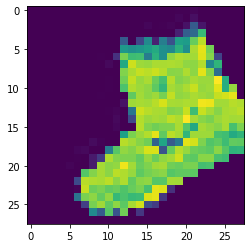

In [99]:
plt.imshow(mnist_train[0][0].numpy().reshape(28, 28))

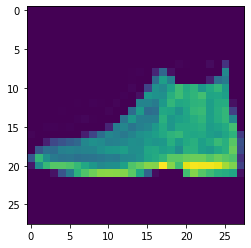

In [100]:
plt.imshow(mnist_test[0][0].numpy().reshape(28, 28))

## Обучение
Чтобы ResNet 18 можно было применить к FashionMNIST (размерности входных и выходных данных подходили), нужно модифицировать первый и последний слой модели.

In [101]:
# берём предобученную модель ResNet 18
model = models.resnet18(pretrained=True)

# устанавливаем для параметров модели requires_grad=False,
# чтобы в архитектуру модели можно было внести изменения
for param in model.parameters():
    param.requires_grad = False

# модифицируем первый слой модели, два основных отличия:
# - принимает на вход 1 канал, а не 3, т. к., в FashionMNIST
#   изображения чёрно-белые, а не RGB
# - шаг сдвига окна свёртки 1, а не 2, соответственно,
#   свёрточный слой рассчитан на изображения 28 * 28, а не 224 * 224
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, padding=3, bias=False)

# модифицируем последний слой модели так,
# чтобы длина каждого предсказания была 10, а не 1000
model.fc = torch.nn.Linear(512, 10)

# сохраняем модифицированные параметры модели на current device
model = model.cuda()

Выводим архитектуру модели. Архитектура правильная!

In [102]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Почти неизменённые функция и кусок кода из предыдущей домашки.

In [103]:
def train_model_mnist(model, loader, criterion, optimizer, train=True):
    curr_loss, curr_acc = 0.0, 0.0
    if train:
        model.train()
    else:
        model.eval()
    for X, y in loader:
        X, y = X.cuda(), y.cuda()
        with torch.set_grad_enabled(train):
            y_pred = model(X)
        loss = criterion(y_pred, y)
        curr_loss += loss.item()
        curr_acc += (y_pred.argmax(dim=1) == y).sum().item()
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return curr_loss / len(loader), curr_acc / len(loader.dataset)

In [104]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [105]:
train_losses = []
test_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss, train_acc = train_model_mnist(model, train_loader, criterion,
                                              optimizer)
    test_loss, test_acc = train_model_mnist(model, test_loader, criterion,
                                            optimizer, train=False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    stats = """
    Epoch: {}, time: {:.1f}s
    train_loss: {:.3f}, train_acc: {:.3f}\ttest_loss: {:.3f}, test_acc: {:.3f}
    """.format(epoch, time.time() - start, train_loss, train_acc,
               test_loss, test_acc)
    print(stats)


    Epoch: 1, time: 27.6s
    train_loss: 1.260, train_acc: 0.555	test_loss: 0.983, test_acc: 0.653
    

    Epoch: 2, time: 27.4s
    train_loss: 0.996, train_acc: 0.647	test_loss: 0.826, test_acc: 0.702
    

    Epoch: 3, time: 27.3s
    train_loss: 0.940, train_acc: 0.665	test_loss: 0.846, test_acc: 0.699
    

    Epoch: 4, time: 27.2s
    train_loss: 0.910, train_acc: 0.678	test_loss: 0.782, test_acc: 0.723
    

    Epoch: 5, time: 27.4s
    train_loss: 0.893, train_acc: 0.680	test_loss: 0.786, test_acc: 0.723
    

    Epoch: 6, time: 27.3s
    train_loss: 0.882, train_acc: 0.685	test_loss: 0.778, test_acc: 0.729
    

    Epoch: 7, time: 27.3s
    train_loss: 0.866, train_acc: 0.691	test_loss: 0.758, test_acc: 0.738
    

    Epoch: 8, time: 27.3s
    train_loss: 0.861, train_acc: 0.693	test_loss: 0.753, test_acc: 0.737
    

    Epoch: 9, time: 27.3s
    train_loss: 0.849, train_acc: 0.696	test_loss: 0.763, test_acc: 0.732
    

    Epoch: 10, time: 27.4s
    train_loss: 0.

In [107]:
stats = """Final accuracy on test sample: {:.3f}
Final loss on training sample: {:.3f}
Final loss on test sample: {:.3f}""".format(test_acc, train_losses[-1],
                                            test_losses[-1])
print(stats)

Final accuracy on test sample: 0.736
Final loss on training sample: 0.842
Final loss on test sample: 0.734


Увы, предобученная ResNet 18 показала по всем параметрам худшие результаты, чем обычная свёрточная сеть из предыдущей домашки (train_loss: 0.148, train_acc: 0.948,	test_loss: 0.332, test_acc: 0.904). :(

## Оценка качества
Посмотрим на другие метрики качества (графики лосса на обучающей и тестовой выборке, confusion matrix).

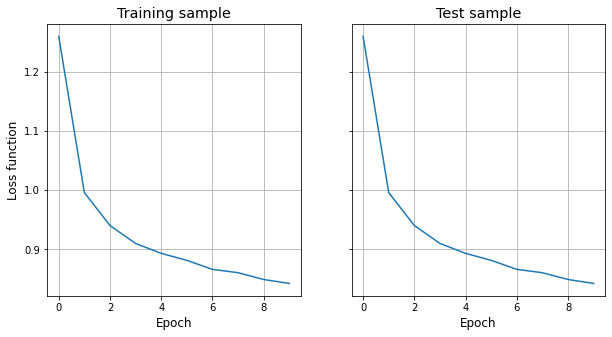

In [106]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax_1.plot(train_losses)
ax_2.plot(train_losses)
ax_1.grid(True)
ax_2.grid(True)
ax_1.set_xlabel('Epoch', fontsize='large')
ax_2.set_xlabel('Epoch', fontsize='large')
ax_1.set_ylabel('Loss function', fontsize='large')
ax_1.set_title('Training sample', fontsize='x-large')
ax_2.set_title('Test sample', fontsize='x-large')
plt.show()

Графики лосса ничего примечательного не говорят. :(

In [111]:
y_true = []
y_pred = []

model.eval()
for X, y in test_loader:
    X, y = X.cuda(), y.cuda()
    y_true.append(y.cpu().numpy())
    y_pred.append(model(X).argmax(dim=1).cpu().numpy())

In [112]:
y_true = list(chain.from_iterable(y_true))
y_pred = list(chain.from_iterable(y_pred))

In [113]:
target_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sheaker', 'Bag', 'Ankle boot']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/Top       0.62      0.80      0.70      1000
     Trouser       0.94      0.94      0.94      1000
    Pullover       0.59      0.55      0.57      1000
       Dress       0.75      0.69      0.72      1000
        Coat       0.55      0.71      0.62      1000
      Sandal       0.92      0.77      0.83      1000
       Shirt       0.48      0.25      0.33      1000
     Sheaker       0.76      0.88      0.82      1000
         Bag       0.82      0.91      0.87      1000
  Ankle boot       0.91      0.87      0.89      1000

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.73      0.74      0.73     10000



Если сравнить это с classification report-ом из предыдущего дз, то становится видно, что абсолютно все метрики качества показывают худшие значения. :(